In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def process_folder(folder_path, c_values, c_total, BOD1, COD1, BOD31, COD31, c_cod_results, c_bod_results, compliance_limits):
    data_df = []  # Data for output CSV
    data_folder = []  # Accumulate data for results

    for filename in os.listdir(folder_path):
        # Skip non-Pickle files
        if not filename.endswith(".pkl"):
            continue

        file_path = os.path.join(folder_path, filename)
        c_list = []
        data_file = []
        
        try:
            data_file = pd.read_pickle(file_path)
        except pd.errors.EmptyDataError:
            print(f"Warning: Empty DataFrame in file {file_path}")
            continue

        if data_file.empty or any(col not in data_file.columns for col in ['bod1', 'cod1', 'bod31', 'cod31', 'snh1', 'snh31']):
            print(f"Warning: Missing columns in file {file_path}")
            continue
        
        # BOD limit calculations
        data_file['BODut'] = abs((compliance_limits["bod_upper"] - data_file["bod31"].min()) / (data_file["bod1"].max() - data_file["bod31"].min()))
        data_file['BODlt'] = abs((compliance_limits["bod_lower"] - data_file["bod31"].min()) / (data_file["bod1"].max() - data_file["bod31"].min()))

        # COD limit calculations
        data_file['CODut'] = abs((compliance_limits["cod_upper"] - data_file["cod31"].min()) / (data_file["cod1"].max() - data_file["cod31"].min()))
        data_file['CODlt'] = abs((compliance_limits["cod_lower"] - data_file["cod31"].min()) / (data_file["cod1"].max() - data_file["cod31"].min()))

        # Lineration of BOD influent and effluent
        data_file["LIN_BODe"] = abs((data_file["bod31"] - data_file["bod31"].min()) / (data_file["bod1"].max() - data_file["bod31"].min()))
        data_file["LIN_BODi"] = abs((data_file["bod1"] - data_file["bod31"].min()) / (data_file["bod1"].max() - data_file["bod31"].min()))

        # Lineration of COD influent and effluent
        data_file["LIN_CODe"] = abs((data_file["cod31"] - data_file["cod31"].min()) / (data_file["cod1"].max() - data_file["cod31"].min()))
        data_file["LIN_CODi"] = abs((data_file["cod1"] - data_file["cod31"].min()) / (data_file["cod1"].max() - data_file["cod31"].min()))

        data_file['BODut-BODeffl'] = (data_file["BODut"] - data_file["LIN_BODe"])
        data_file['CODut-CODeffl'] = (data_file["CODut"] - data_file["LIN_CODe"])
        data_file['BODlt-BODeffl'] = (data_file["BODlt"] - data_file["LIN_BODe"])
        data_file['CODlt-CODeffl'] = (data_file["CODlt"] - data_file["LIN_CODe"])
       
        data_file["bodp"] = -(compliance_limits["bod_pc"] * data_file["LIN_BODi"]) + data_file["LIN_BODi"] - data_file["LIN_BODe"]
        data_file["codp"] = -(compliance_limits["cod_pc"] * data_file["LIN_CODi"]) + data_file["LIN_CODi"] - data_file["LIN_CODe"]

        data_file["max1"] = data_file[['BODlt-BODeffl', 'bodp']].max(axis=1)
        data_file['c_BOD'] = data_file[['BODut-BODeffl', 'max1']].min(axis=1)
        data_file["max2"] = data_file[['CODlt-CODeffl', 'codp']].max(axis=1)
        data_file['c_COD'] = data_file[['CODut-CODeffl', 'max2']].min(axis=1)

        c_bod_list = data_file['c_BOD'].tolist()
        c_cod_list = data_file['c_COD'].tolist()

        # FLAGS
        flag_BODlt = False if data_file['BODlt-BODeffl'].min() < 0 else True
        flag_CODlt = False if data_file['CODlt-CODeffl'].min() < 0 else True

        flag_reduction_bod = False if data_file["bodp"].min() < 0 else True
        flag_reduction_cod = False if data_file["codp"].min() < 0 else True

        flag_BOD = False if data_file['BODut-BODeffl'].min() < 0 else True
        flag_COD = False if data_file['CODut-CODeffl'].min() < 0 else True

        for c_bod, c_cod in zip(c_bod_list, c_cod_list):
            failure_type = "COMPLIANT"
            failure_source = None

            if c_bod < 0:
                if flag_BODlt is False and flag_reduction_bod is False:
                    failure_type = "LUT exceedance"
                    failure_source = "BOD"
                else:
                    failure_type = "Maximum limit failure"
                    failure_source = "BOD"

            if c_cod < 0:
                if flag_CODlt is False and flag_reduction_cod is False:
                    failure_type = "LUT exceedance"
                    failure_source = "COD"
                else:
                    failure_type = "Maximum limit failure"
                    failure_source = "COD"

            # Determine the source of failure if both conditions are met
            if failure_type != "COMPLIANT" and failure_source is None:
                if c_bod < 0 and c_cod < 0:
                    failure_source = "BOTH"
                elif c_bod < 0:
                    failure_source = "BOD"
                elif c_cod < 0:
                    failure_source = "COD"
            
            data_df.append({
                'bod': c_bod,
                'cod': c_cod,
                'min': min(c_bod, c_cod),
                'failtype': failure_type,
                'source': failure_source
            })
            
            c_list.append((min(c_bod, c_cod), failure_type, failure_source))

            if not c_list:
                print(f"Warning: No valid rows in file {file_path}")
                continue

        c_values.append(min(c_list)[0])
        c_total.append(c_list)
        BOD1.append(data_file['bod1'].tolist())
        COD1.append(data_file['cod1'].tolist())
        BOD31.append(data_file['bod31'].tolist())
        COD31.append(data_file['cod31'].tolist())
        c_cod_results.append(c_cod_list)
        c_bod_results.append(c_bod_list)

        df = pd.DataFrame(data_df)
        csv_name = os.path.basename(folder_path)
        df.to_csv(f'{csv_name}.csv', index=False) 
        
        # Concat data file to data_folder
        data_folder.append(data_file)
        
    # Return the concatenated results from all the files in the folder
    if not data_folder == []:
        # Create a DataFrame from the accumulated data
        result_df =  pd.concat(data_folder, ignore_index=True)
        return result_df
    else:
        print(f"Warning: No data to return for folder {folder_path}")
        return pd.DataFrame()  # Return an empty DataFrame if no data

# CONSTANTS
BOD_UPPER = 50
BOD_LOWER = 25
COD_UPPER = 250
COD_LOWER = 125
BOD_PC = 0.7
COD_PC = 0.75

# Define folder paths
root_path = os.getcwd() + '\\'

# sub folders
folder_path_1 = root_path + 'baseline'
folder_path_2 = root_path + '1.3'
folder_path_3 = root_path + '1.5'
folder_path_4 = root_path + '1.9'

# Initialize lists for storing data
c_values_baseline = []
c_total_baseline = []
c_cod_baseline = []
c_bod_baseline = []
BOD1_baseline = []
COD1_baseline = []
BOD31_baseline = []
COD31_baseline = []

c_values_shift130 = []
c_total_shift130 = []
c_cod_shift130 = []
c_bod_shift130 = []
BOD1_shift130 = []
COD1_shift130 = []
BOD31_shift130 = []
COD31_shift130 = []

c_values_shift150 = []
c_total_shift150 = []
c_cod_shift150 = []
c_bod_shift150 = []
BOD1_shift150 = []
COD1_shift150 = []
BOD31_shift150 = []
COD31_shift150 = []

c_values_shift190 = []
c_total_shift190 = []
c_cod_shift190 = []
c_bod_shift190 = []
BOD1_shift190 = []
COD1_shift190 = []
BOD31_shift190 = []
COD31_shift190 = []

compliance_limits = {
    "bod_upper": BOD_UPPER,
    "bod_lower": BOD_LOWER,
    "cod_upper": COD_UPPER,
    "cod_lower": COD_LOWER,
    "bod_pc" : BOD_PC,
    "cod_pc" : COD_PC
}

# Process each folder
result_baseline = process_folder(folder_path_1, c_values_baseline, c_total_baseline,  BOD1_baseline, COD1_baseline, BOD31_baseline, COD31_baseline, c_cod_baseline, c_bod_baseline, compliance_limits)
results_1_3 = process_folder(folder_path_2, c_values_shift130, c_total_shift130,  BOD1_shift130, COD1_shift130, BOD31_shift130, COD31_shift130, c_cod_shift130, c_bod_shift130, compliance_limits)
results_1_5 = process_folder(folder_path_3, c_values_shift150, c_total_shift150,  BOD1_shift150, COD1_shift150, BOD31_shift150, COD31_shift150, c_bod_shift150, c_cod_shift150, compliance_limits)
results_1_9 = process_folder(folder_path_4, c_values_shift190, c_total_shift190,  BOD1_shift190, COD1_shift190, BOD31_shift190, COD31_shift190, c_bod_shift190, c_cod_shift190, compliance_limits)


datasets = [
    (result_baseline, "Baseline"),
    (results_1_3, "Shift 130%"),
    (results_1_5, "Shift 150%"),
    (results_1_9, "Shift 190%")
]

title = ["Baseline", "Shift 130%", "Shift 150%", "Shift 190%"]

# Define the x and y columns for each case
xy_columns = [
    ("LIN_BODi", "c_BOD"),
    ("LIN_BODe", "c_BOD"),
    ("LIN_CODi", "c_COD"),
    ("LIN_CODe", "c_COD")
]




#=INDICE(A2:E752,CONFRONTA(MIN(C2:C752),C2:C752,0),)

In [23]:
# Concatenate the lists for the baseline scenario 
c_total_baseline = np.concatenate([result[1:] for result in c_total_baseline])

bodinfl1_baseline = np.concatenate([result[1:] for result in BOD1_baseline])
bodeffl31_baseline = np.concatenate([result[1:] for result in BOD31_baseline])
codinfl1_baseline = np.concatenate([result[1:] for result in COD1_baseline])
codeffl31_baseline = np.concatenate([result[1:] for result in COD31_baseline])


# Concatenate the lists for the scenario with a factor of 1.3
c_total_shift130 = np.concatenate([result[1:] for result in c_total_shift130])

bodinfl1_shift130 = np.concatenate([result[1:] for result in BOD1_shift130])
bodeffl31_shift130 = np.concatenate([result[1:] for result in BOD31_shift130])
codinfl1_shift130 = np.concatenate([result[1:] for result in COD1_shift130])
codeffl31_shift130 = np.concatenate([result[1:] for result in COD31_shift130])


# Concatenate the lists for the scenario with a factor of 1.5
c_total_shift150 = np.concatenate([result[1:] for result in c_total_shift150])

bodinfl1_shift150 = np.concatenate([result[1:] for result in BOD1_shift150])
bodeffl31_shift150 = np.concatenate([result[1:] for result in BOD31_shift150])
codinfl1_shift150 = np.concatenate([result[1:] for result in COD1_shift150])
codeffl31_shift150 = np.concatenate([result[1:] for result in COD31_shift150])


# Concatenate the lists for the scenario with a factor of 1.5
c_total_shift190 = np.concatenate([result[1:] for result in c_total_shift190])

bodinfl1_shift190 = np.concatenate([result[1:] for result in BOD1_shift190])
bodeffl31_shift190 = np.concatenate([result[1:] for result in BOD31_shift190])
codinfl1_shift190 = np.concatenate([result[1:] for result in COD1_shift190])
codeffl31_shift190 = np.concatenate([result[1:] for result in COD31_shift190])


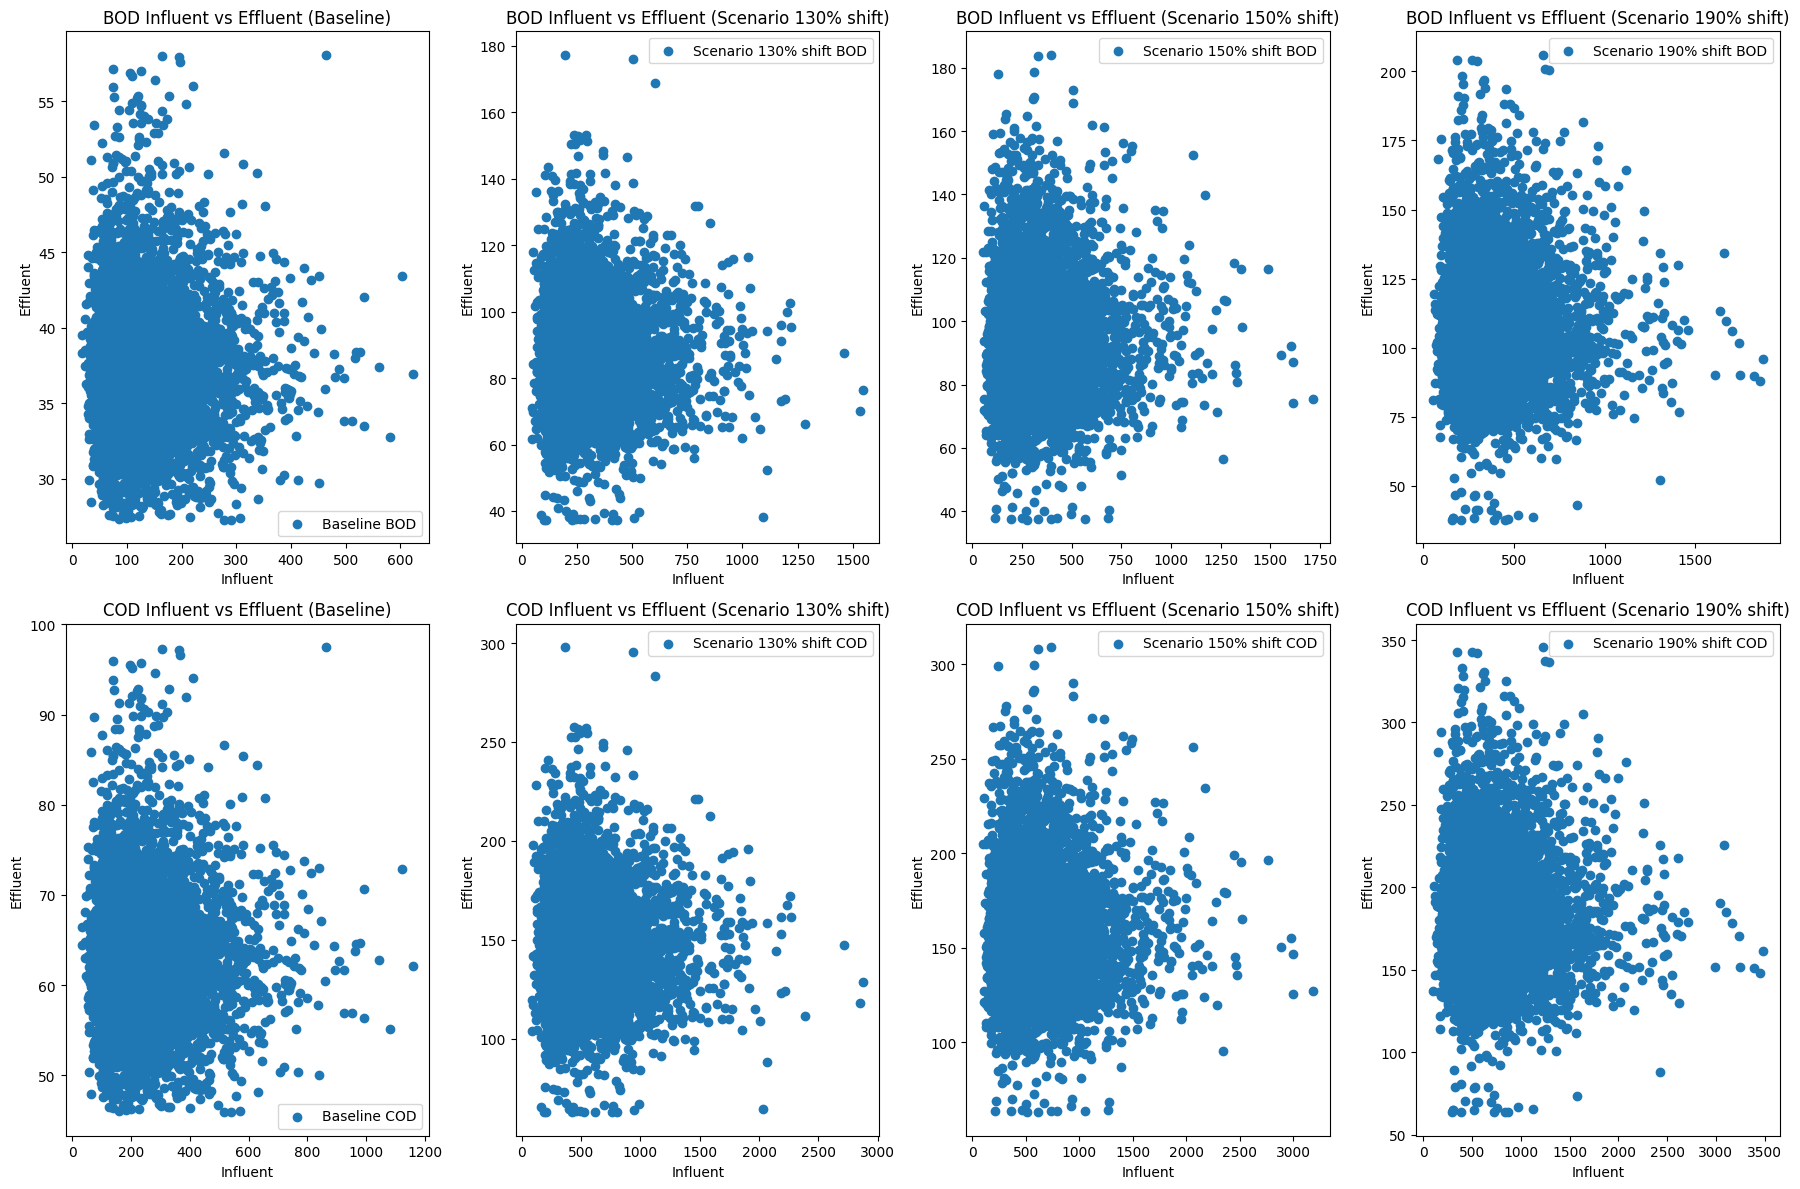

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure for each plot
fig, axs = plt.subplots(2, 4, figsize=(18, 12))  # 3 rows, 4 columns

# Define the titles and data for each scenario and parameter
parameters = ['BOD', 'COD']
scenarios = ['Baseline', 'Scenario 130% shift', 'Scenario 150% shift', 'Scenario 190% shift']

param_to_influent = {
    'BOD': [bodinfl1_baseline, bodinfl1_shift130, bodinfl1_shift150, bodinfl1_shift190],
    'COD': [codinfl1_baseline, codinfl1_shift130, codinfl1_shift150, codinfl1_shift190],
}

param_to_effluent = {
    'BOD': [bodeffl31_baseline, bodeffl31_shift130, bodeffl31_shift150, bodeffl31_shift190],
    'COD': [codeffl31_baseline, codeffl31_shift130, codeffl31_shift150, codeffl31_shift190],
}

# Loop through parameters and scenarios to generate the plots
for i, param in enumerate(parameters):
    for j, scenario in enumerate(scenarios):
        # Sort the influent and effluent data
        influent_sorted = np.sort(param_to_influent[param][j])
        # Sort the corresponding effluent data based on the sorted influent data
        effluent_sorted = np.array(param_to_effluent[param][j])[np.argsort(param_to_influent[param][j])]
        
        # Plot the sorted data
        axs[i, j].scatter(influent_sorted, effluent_sorted, label=f'{scenario} {param}')
        axs[i, j].set_xlabel('Influent')
        axs[i, j].set_ylabel('Effluent')
        axs[i, j].set_title(f'{param} Influent vs Effluent ({scenario})')
        axs[i, j].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()





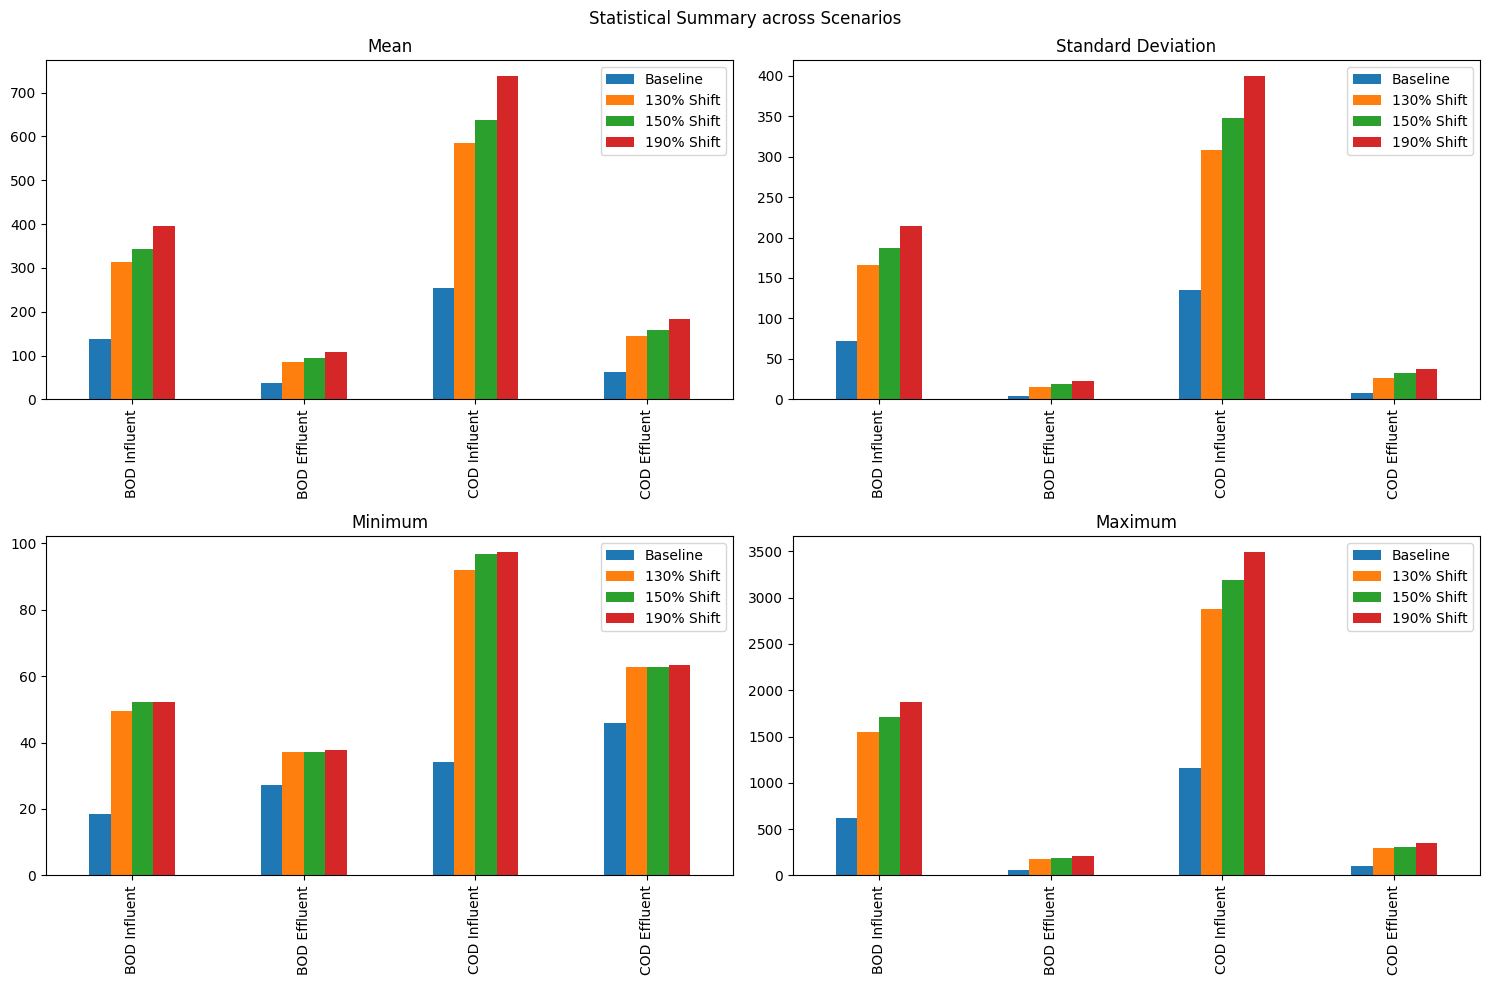

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example arrays for each scenario (replace these with your actual concatenated arrays)
# Assuming the lists are already concatenated as described before

# Create DataFrames and calculate statistics
stats_baseline = pd.DataFrame({
    'mean': [bodinfl1_baseline.mean(), bodeffl31_baseline.mean(), codinfl1_baseline.mean(), codeffl31_baseline.mean()],
    'std': [bodinfl1_baseline.std(), bodeffl31_baseline.std(), codinfl1_baseline.std(), codeffl31_baseline.std()],
    'min': [bodinfl1_baseline.min(), bodeffl31_baseline.min(), codinfl1_baseline.min(), codeffl31_baseline.min()],
    'max': [bodinfl1_baseline.max(), bodeffl31_baseline.max(), codinfl1_baseline.max(), codeffl31_baseline.max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent'])

# Repeat for other scenarios
stats_shift130 = pd.DataFrame({
    'mean': [bodinfl1_shift130.mean(), bodeffl31_shift130.mean(), codinfl1_shift130.mean(), codeffl31_shift130.mean()],
    'std': [bodinfl1_shift130.std(), bodeffl31_shift130.std(), codinfl1_shift130.std(), codeffl31_shift130.std()],
    'min': [bodinfl1_shift130.min(), bodeffl31_shift130.min(), codinfl1_shift130.min(), codeffl31_shift130.min()],
    'max': [bodinfl1_shift130.max(), bodeffl31_shift130.max(), codinfl1_shift130.max(), codeffl31_shift130.max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent'])

stats_shift150 = pd.DataFrame({
    'mean': [bodinfl1_shift150.mean(), bodeffl31_shift150.mean(), codinfl1_shift150.mean(), codeffl31_shift150.mean()],
    'std': [bodinfl1_shift150.std(), bodeffl31_shift150.std(), codinfl1_shift150.std(), codeffl31_shift150.std()],
    'min': [bodinfl1_shift150.min(), bodeffl31_shift150.min(), codinfl1_shift150.min(), codeffl31_shift150.min()],
    'max': [bodinfl1_shift150.max(), bodeffl31_shift150.max(), codinfl1_shift150.max(), codeffl31_shift150.max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent'])

stats_shift190 = pd.DataFrame({
    'mean': [bodinfl1_shift190.mean(), bodeffl31_shift190.mean(), codinfl1_shift190.mean(), codeffl31_shift190.mean()],
    'std': [bodinfl1_shift190.std(), bodeffl31_shift190.std(), codinfl1_shift190.std(), codeffl31_shift190.std()],
    'min': [bodinfl1_shift190.min(), bodeffl31_shift190.min(), codinfl1_shift190.min(), codeffl31_shift190.min()],
    'max': [bodinfl1_shift190.max(), bodeffl31_shift190.max(), codinfl1_shift190.max(), codeffl31_shift190.max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent'])

# Combine all the statistics into one DataFrame
combined_stats = pd.concat([stats_baseline, stats_shift130, stats_shift150, stats_shift190], axis=1)
combined_stats.columns = pd.MultiIndex.from_product([['Baseline', '130% Shift', '150% Shift', '190% Shift'], ['mean', 'std', 'min', 'max']])

# Plot the statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Statistical Summary across Scenarios')

combined_stats.xs('mean', level=1, axis=1).plot(kind='bar', ax=axes[0, 0], title='Mean')
combined_stats.xs('std', level=1, axis=1).plot(kind='bar', ax=axes[0, 1], title='Standard Deviation')
combined_stats.xs('min', level=1, axis=1).plot(kind='bar', ax=axes[1, 0], title='Minimum')
combined_stats.xs('max', level=1, axis=1).plot(kind='bar', ax=axes[1, 1], title='Maximum')

plt.tight_layout()
plt.show()


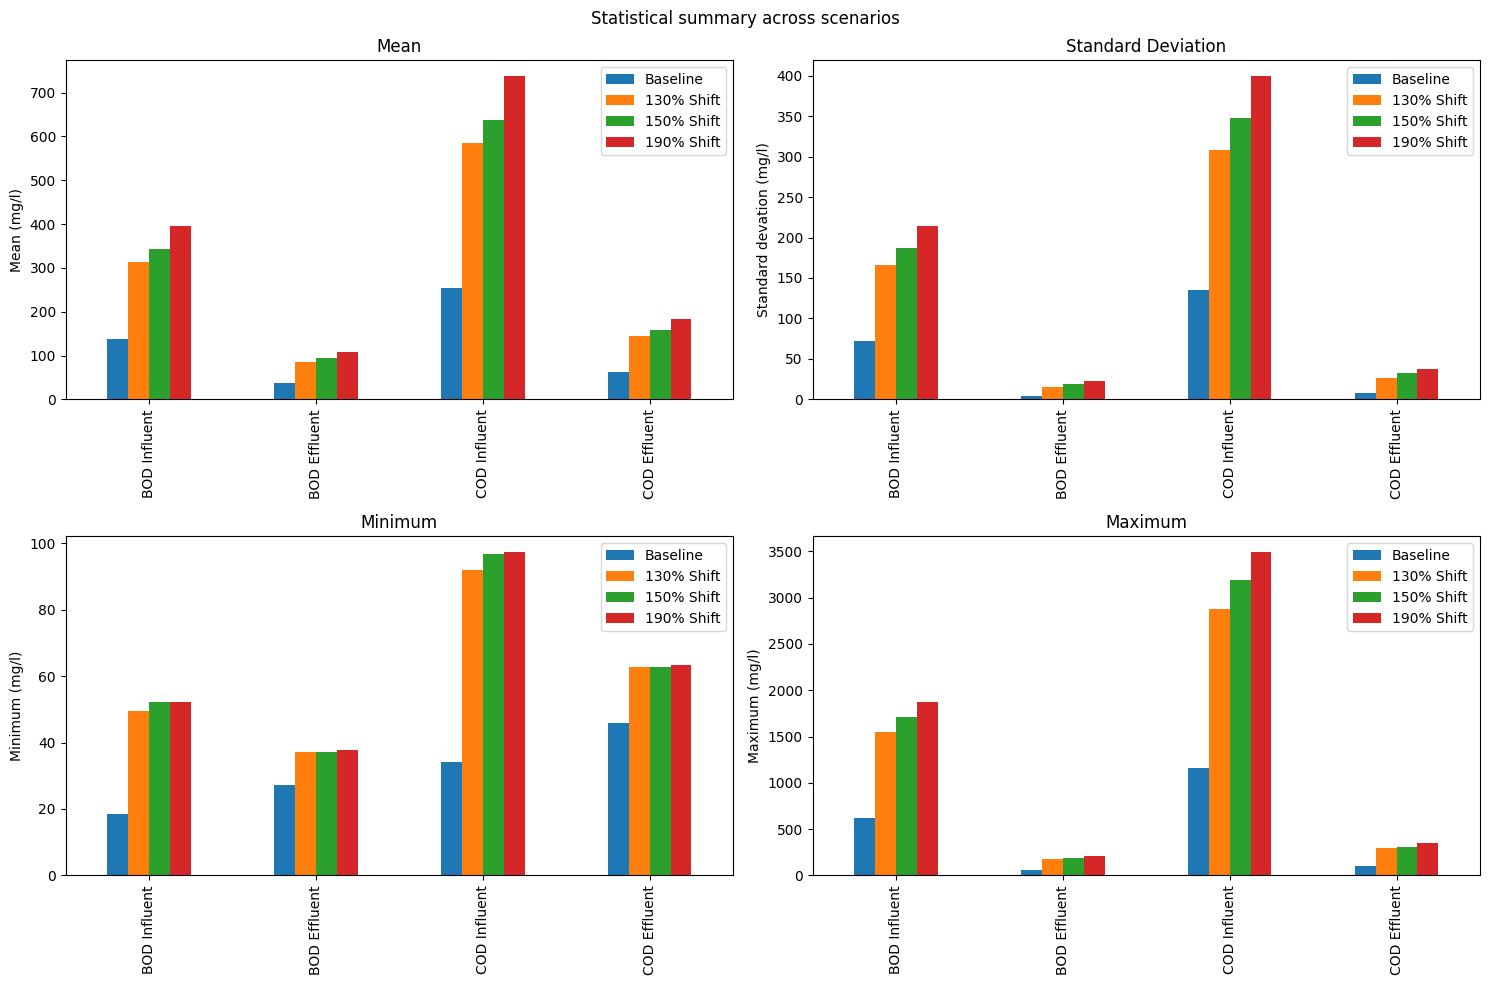

In [26]:
# Plot the statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Statistical summary across scenarios')

# Plotting the mean
combined_stats.xs('mean', level=1, axis=1).plot(kind='bar', ax=axes[0, 0], title='Mean')
axes[0, 0].set_ylabel('Mean (mg/l)')

# Plotting the standard deviation
combined_stats.xs('std', level=1, axis=1).plot(kind='bar', ax=axes[0, 1], title='Standard Deviation')
axes[0, 1].set_ylabel('Standard devation (mg/l)')

# Plotting the minimum
combined_stats.xs('min', level=1, axis=1).plot(kind='bar', ax=axes[1, 0], title='Minimum')
axes[1, 0].set_ylabel('Minimum (mg/l)')

# Plotting the maximum
combined_stats.xs('max', level=1, axis=1).plot(kind='bar', ax=axes[1, 1], title='Maximum')
axes[1, 1].set_ylabel('Maximum (mg/l)')

plt.tight_layout()
plt.show()


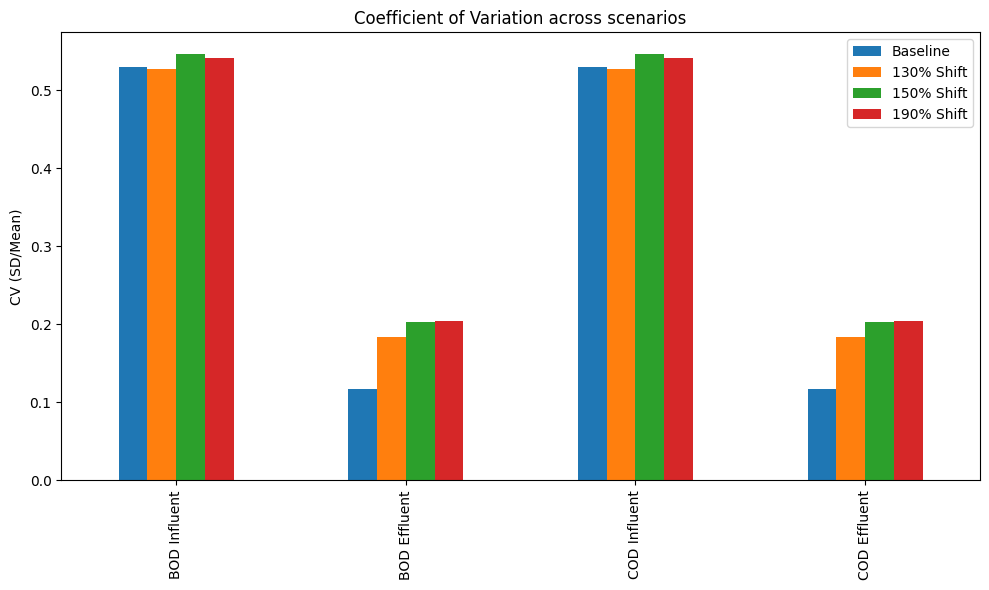

In [27]:
# Compute Coefficient of Variation (CV)
cv = combined_stats.xs('std', level=1, axis=1) / combined_stats.xs('mean', level=1, axis=1)

# Plot the Coefficient of Variation
fig, ax = plt.subplots(figsize=(10, 6))
cv.plot(kind='bar', ax=ax, title='Coefficient of Variation across scenarios')
ax.set_ylabel('CV (SD/Mean)')
plt.tight_layout()
plt.show()


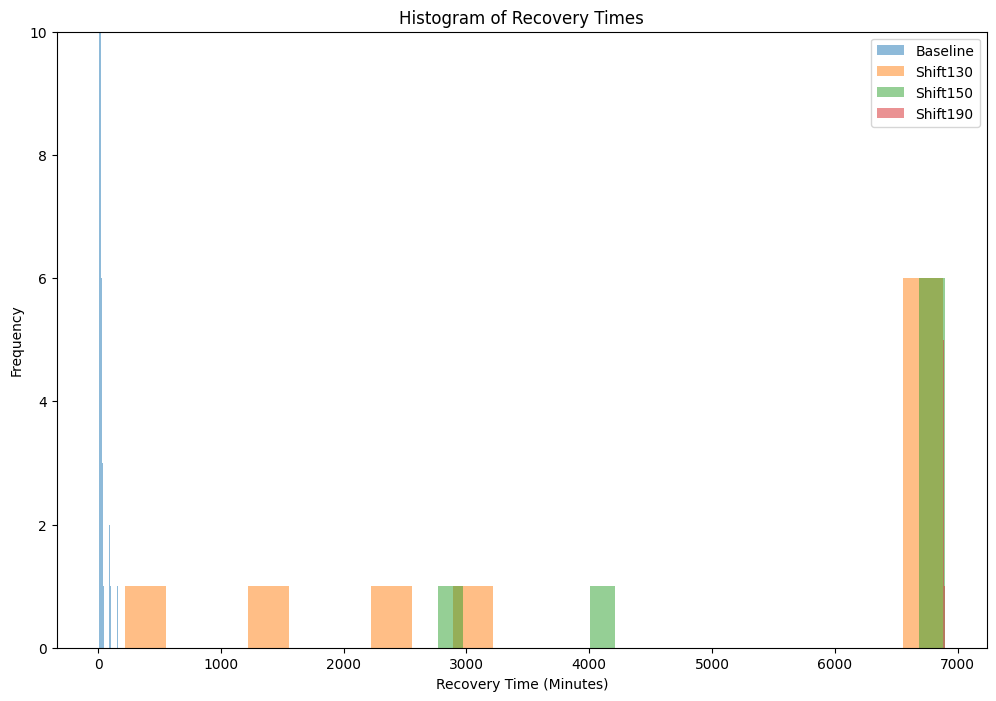

Mean recovery time for baseline: 12.579310344827586 minutes
Mean recovery time for shift130: 4804.3008 minutes
Mean recovery time for shift150: 6018.048000000001 minutes
Mean recovery time for shift190: 6883.035428571428 minutes


In [28]:
def compute_recovery_time(series, time_step=0.08):
    non_compliance_duration = 0
    recovery_times = []
    in_non_compliance = False

    for _, failure_type, _ in series: 
        if failure_type in ['Maximum Limit Failure', 'LUT exceedance']:
            if not in_non_compliance:
                in_non_compliance = True
            non_compliance_duration += 1
        else:
            if in_non_compliance:
                recovery_time = round(non_compliance_duration * time_step, 2)
                recovery_times.append(recovery_time)
                non_compliance_duration = 0
                in_non_compliance = False

    # Check for ongoing non-compliance at the end of the series
    if in_non_compliance:
        recovery_time = round(non_compliance_duration * time_step, 2)
        recovery_times.append(recovery_time)

    return recovery_times


# Compute recovery times for each series
recovery_times_baseline = compute_recovery_time(c_total_baseline)
recovery_times_shift130 = compute_recovery_time(c_total_shift130)
recovery_times_shift150 = compute_recovery_time(c_total_shift150)
recovery_times_shift190 = compute_recovery_time(c_total_shift190)


# Define the bins for the histogram
bins = 20
time_step = 0.08
hours_day = 24
minutes_hour = 60

# Convert recovery times to minutes
recovery_times_baseline_minutes = [time * time_step * hours_day * minutes_hour for time in recovery_times_baseline]
recovery_times_shift130_minutes = [time * time_step * hours_day * minutes_hour for time in recovery_times_shift130]
recovery_times_shift150_minutes = [time * time_step * hours_day * minutes_hour for time in recovery_times_shift150]
recovery_times_shift190_minutes = [time * time_step * hours_day * minutes_hour for time in recovery_times_shift190]

# Plot histograms for each scenario
plt.figure(figsize=(12, 8))

plt.hist(recovery_times_baseline_minutes, bins=bins, alpha=0.5, label='Baseline')
plt.hist(recovery_times_shift130_minutes, bins=bins, alpha=0.5, label='Shift130')
plt.hist(recovery_times_shift150_minutes, bins=bins, alpha=0.5, label='Shift150')
plt.hist(recovery_times_shift190_minutes, bins=bins, alpha=0.5, label='Shift190')

plt.xlabel('Recovery Time (Minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Recovery Times')
plt.legend()
plt.ylim(0,10)
plt.show()
# Convert lists to NumPy arrays
recovery_times_baseline_minutes = np.array(recovery_times_baseline_minutes)
recovery_times_shift130_minutes = np.array(recovery_times_shift130_minutes)
recovery_times_shift150_minutes = np.array(recovery_times_shift150_minutes)
recovery_times_shift190_minutes = np.array(recovery_times_shift190_minutes)

# Calculate the mean for each dataset
mean_baseline = np.mean(recovery_times_baseline_minutes)
mean_shift130 = np.mean(recovery_times_shift130_minutes)
mean_shift150 = np.mean(recovery_times_shift150_minutes)
mean_shift190 = np.mean(recovery_times_shift190_minutes)

print(f"Mean recovery time for baseline: {mean_baseline} minutes")
print(f"Mean recovery time for shift130: {mean_shift130} minutes")
print(f"Mean recovery time for shift150: {mean_shift150} minutes")
print(f"Mean recovery time for shift190: {mean_shift190} minutes")



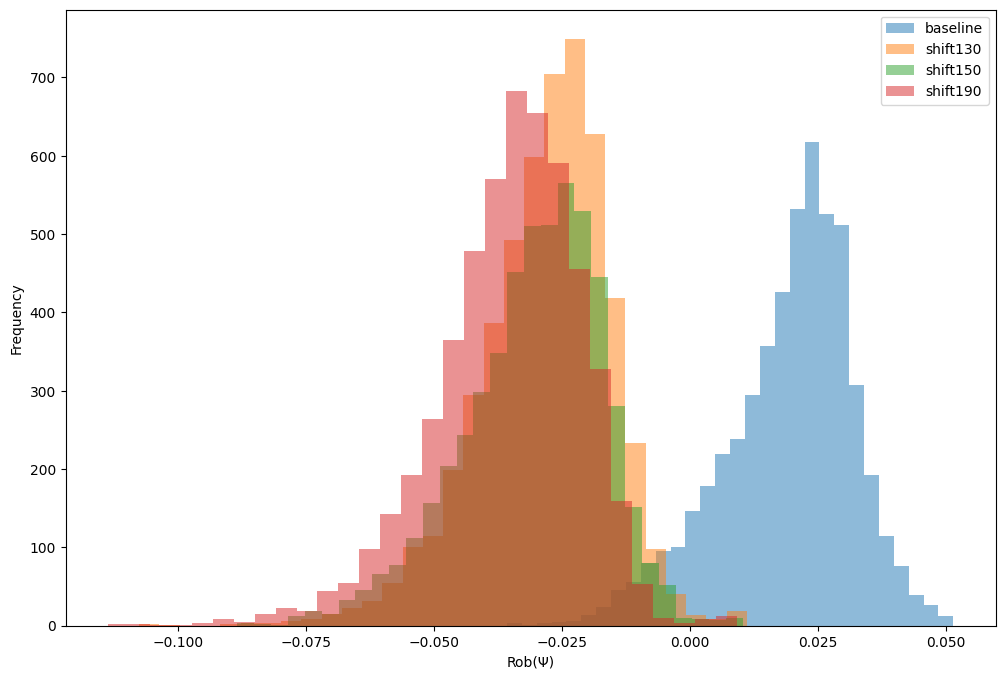

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to flatten nested lists and clean data
def flatten_and_clean(lst):
    flat_list = [item for sublist in lst for item in sublist]
    clean_list = []
    
    for x in flat_list:
        try:
            # Convert to float and check if it's a valid number
            float_x = float(x)
            if not np.isnan(float_x):
                clean_list.append(float_x)
        except (ValueError, TypeError):
            # Skip values that cannot be converted to float
            continue

    return clean_list

# Extract and flatten 'c_total' data for each scenario
c_total_data = {
    "baseline": flatten_and_clean(c_total_baseline),
    "shift130": flatten_and_clean(c_total_shift130),
    "shift150": flatten_and_clean(c_total_shift150),
    "shift190": flatten_and_clean(c_total_shift190)
}

# Plot the histogram
plt.figure(figsize=(12, 8))

# Plot histogram for each scenario
for scenario, values in c_total_data.items():
    plt.hist(values, bins=30, alpha=0.5, label=scenario)

# Add labels and title
plt.xlabel('Rob(Ψ)')
plt.ylabel('Frequency')
#plt.title('Histogram of c_total for Different Scenarios')
plt.legend(loc='upper right')

# Show the plot
plt.show()




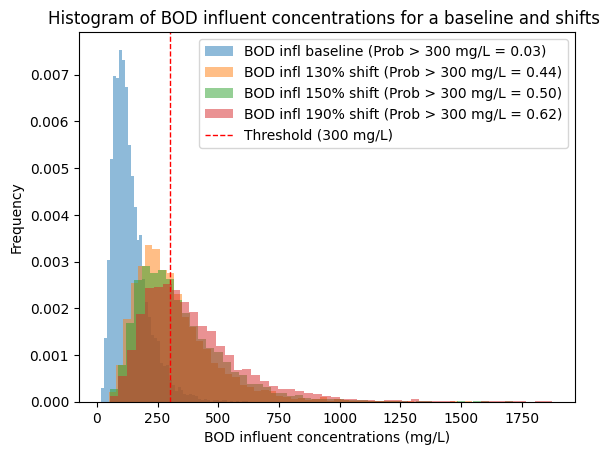

In [30]:

# Count the number of values above 300 mg/L in bodinfl1_baseline
count_baseline_above_300 = sum(1 for value in bodinfl1_baseline if value > 300)
# Calculate the probability
probability_baseline_above_300 = count_baseline_above_300 / len(bodinfl1_baseline)

# Count the number of values above 300 mg/L in bodinfl1_shift130
count_shift130_above_300 = sum(1 for value in bodinfl1_shift130 if value > 300)
# Calculate the probability
probability_shift130_above_300 = count_shift130_above_300 / len(bodinfl1_shift130)

# Count the number of values above 300 mg/L in bodinfl1_shift150
count_shift150_above_300 = sum(1 for value in bodinfl1_shift150 if value > 300)
# Calculate the probability
probability_shift150_above_300 = count_shift150_above_300 / len(bodinfl1_shift150)

# Count the number of values above 300 mg/L in bodinfl1_shift190
count_shift190_above_300 = sum(1 for value in bodinfl1_shift190 if value > 300)
# Calculate the probability
probability_shift190_above_300 = count_shift190_above_300 / len(bodinfl1_shift190)

# Plot histogram for bodinfl_80
plt.hist(bodinfl1_baseline, bins=50, density=True, alpha=0.5, label=f'BOD infl baseline (Prob > 300 mg/L = {probability_baseline_above_300:.2f})')
plt.hist(bodinfl1_shift130, bins=50, density=True, alpha=0.5, label=f'BOD infl 130% shift (Prob > 300 mg/L = {probability_shift130_above_300:.2f})')
plt.hist(bodinfl1_shift150, bins=50, density=True, alpha=0.5, label=f'BOD infl 150% shift (Prob > 300 mg/L = {probability_shift150_above_300:.2f})')
plt.hist(bodinfl1_shift190, bins=50, density=True, alpha=0.5, label=f'BOD infl 190% shift (Prob > 300 mg/L = {probability_shift190_above_300:.2f})')
# Add a dotted line at 300 mg/L
plt.axvline(x=300, color='r', linestyle='--', linewidth=1, label='Threshold (300 mg/L)')

# Set labels and title
plt.xlabel('BOD influent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of BOD influent concentrations for a baseline and shifts ')

plt.legend()

# Show the plot
plt.show()

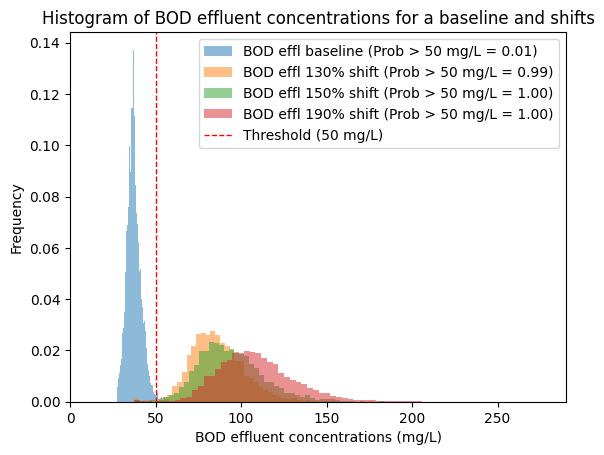

In [31]:
# Count the number of values above 125 mg/L in bodeffl31_baseline
count_baseline_above_50 = sum(1 for value in bodeffl31_baseline if value > 50)
# Calculate the probability
probability_baseline_above_50 = count_baseline_above_50 / len(bodeffl31_baseline)

# Count the number of values above 125 mg/L in bodeffl31_shift130
count_shift130_above_50 = sum(1 for value in bodeffl31_shift130 if value > 50)
# Calculate the probability
probability_shift130_above_50 = count_shift130_above_50 / len(bodeffl31_shift130)

# Count the number of values above 125 mg/L in bodeffl31_shift150
count_shift150_above_50 = sum(1 for value in bodeffl31_shift150 if value > 50)
# Calculate the probability
probability_shift150_above_50 = count_shift150_above_50 / len(bodeffl31_shift150)

# Count the number of values above 125 mg/L in bodeffl31_shift150
count_shift190_above_50 = sum(1 for value in bodeffl31_shift190 if value > 50)
# Calculate the probability
probability_shift190_above_50 = count_shift190_above_50 / len(bodeffl31_shift190)

# Plot histogram for bodeffl31
plt.hist(bodeffl31_baseline, bins=50, density=True, alpha=0.5, label=f'BOD effl baseline (Prob > 50 mg/L = {probability_baseline_above_50:.2f})')
plt.hist(bodeffl31_shift130, bins=50, density=True, alpha=0.5, label=f'BOD effl 130% shift (Prob > 50 mg/L = {probability_shift130_above_50:.2f})')
plt.hist(bodeffl31_shift150, bins=50, density=True, alpha=0.5, label=f'BOD effl 150% shift (Prob > 50 mg/L = {probability_shift150_above_50:.2f})')
plt.hist(bodeffl31_shift190, bins=50, density=True, alpha=0.5, label=f'BOD effl 190% shift (Prob > 50 mg/L = {probability_shift190_above_50:.2f})')

# Add a dotted line at 125 mg/L
plt.axvline(x=50, color='r', linestyle='--', linewidth=1, label='Threshold (50 mg/L)')

# Set labels and title
plt.xlabel('BOD effluent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of BOD effluent concentrations for a baseline and shifts')
# Set the x-axis limits
plt.xlim(0, 290)
plt.legend()

# Show the plot
plt.show()


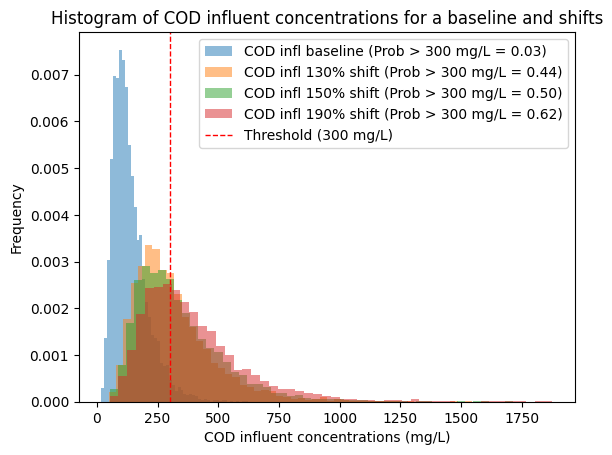

In [32]:
# Count the number of values above 300 mg/L in bodinfl1_baseline
count_baseline_above_300 = sum(1 for value in bodinfl1_baseline if value > 300)
# Calculate the probability
probability_baseline_above_300 = count_baseline_above_300 / len(bodinfl1_baseline)

# Count the number of values above 300 mg/L in bodinfl1_shift130
count_shift130_above_300 = sum(1 for value in bodinfl1_shift130 if value > 300)
# Calculate the probability
probability_shift130_above_300 = count_shift130_above_300 / len(bodinfl1_shift130)

# Count the number of values above 300 mg/L in bodinfl1_shift150
count_shift150_above_300 = sum(1 for value in bodinfl1_shift150 if value > 300)
# Calculate the probability
probability_shift150_above_300 = count_shift150_above_300 / len(bodinfl1_shift150)

# Count the number of values above 300 mg/L in bodinfl1_shift150
count_shift190_above_300 = sum(1 for value in bodinfl1_shift190 if value > 300)
# Calculate the probability
probability_shift190_above_300 = count_shift190_above_300 / len(bodinfl1_shift190)

# Plot histogram for bodinfl_80
plt.hist(bodinfl1_baseline, bins=50, density=True, alpha=0.5, label=f'COD infl baseline (Prob > 300 mg/L = {probability_baseline_above_300:.2f})')
plt.hist(bodinfl1_shift130, bins=50, density=True, alpha=0.5, label=f'COD infl 130% shift (Prob > 300 mg/L = {probability_shift130_above_300:.2f})')
plt.hist(bodinfl1_shift150, bins=50, density=True, alpha=0.5, label=f'COD infl 150% shift (Prob > 300 mg/L = {probability_shift150_above_300:.2f})')
plt.hist(bodinfl1_shift190, bins=50, density=True, alpha=0.5, label=f'COD infl 190% shift (Prob > 300 mg/L = {probability_shift190_above_300:.2f})')
# Add a dotted line at 300 mg/L
plt.axvline(x=300, color='r', linestyle='--', linewidth=1, label='Threshold (300 mg/L)')

# Set labels and title
plt.xlabel('COD influent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of COD influent concentrations for a baseline and shifts')

plt.legend()

# Show the plot
plt.show()


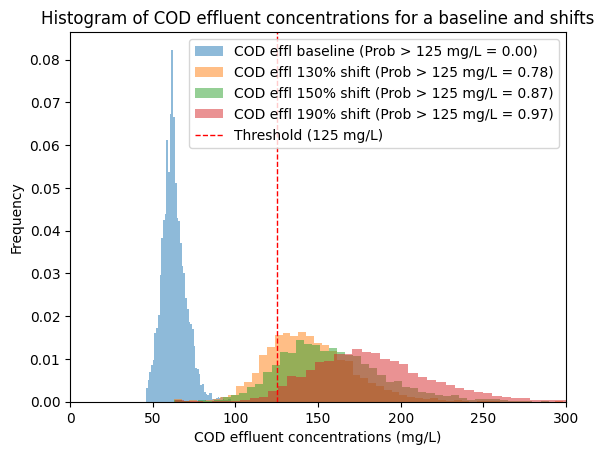

In [33]:
#baseline
count_baseline_above_125 = sum(1 for value in codeffl31_baseline if value > 125)
# Calculate the probability
probability_baseline_above_125 = count_baseline_above_125 / len(codeffl31_baseline)

#130
count_shift130_above_125 = sum(1 for value in codeffl31_shift130 if value > 125)
# Calculate the probability
probability_shift130_above_125 = count_shift130_above_125 / len(codeffl31_shift130)

#150
count_shift150_above_125 = sum(1 for value in codeffl31_shift150 if value > 125)
# Calculate the probability
probability_shift150_above_125 = count_shift150_above_125 / len(codeffl31_shift150)

#190
count_shift190_above_125 = sum(1 for value in codeffl31_shift190 if value > 125)
# Calculate the probability
probability_shift190_above_125 = count_shift190_above_125 / len(codeffl31_shift190)

# Plot histogram for codeffl31
plt.hist(codeffl31_baseline, bins=50, density=True, alpha=0.5, label=f'COD effl baseline (Prob > 125 mg/L = {probability_baseline_above_125:.2f})')
plt.hist(codeffl31_shift130, bins=50, density=True, alpha=0.5, label=f'COD effl 130% shift (Prob > 125 mg/L = {probability_shift130_above_125:.2f})')
plt.hist(codeffl31_shift150, bins=50, density=True, alpha=0.5, label=f'COD effl 150% shift (Prob > 125 mg/L = {probability_shift150_above_125:.2f})')
plt.hist(codeffl31_shift190, bins=50, density=True, alpha=0.5, label=f'COD effl 190% shift (Prob > 125 mg/L = {probability_shift190_above_125:.2f})')

# Add a dotted line at 125 mg/L
plt.axvline(x=125, color='r', linestyle='--', linewidth=1, label='Threshold (125 mg/L)')

# Set labels and title
plt.xlabel('COD effluent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of COD effluent concentrations for a baseline and shifts')
# Set the x-axis limits
plt.xlim(0, 300)
plt.legend()

# Show the plot
plt.show()
